# Model development notebook without GPU

## Imports

In [8]:
import model_tools as mt
import tensorflow as tf
import matplotlib
import numpy as np
import sklearn
from sklearn.utils import shuffle
import random
import scipy.ndimage
random.seed(42)
print('model_tools version:', mt.__version__)
print('tensorflow version: ', tf.__version__)
print('matplotlib version:', matplotlib.__version__)
print('numpy version: ', np.__version__)
print('sklearn version:', sklearn.__version__)
print('scipy version:', scipy.__version__)

model_tools version: 1.1.3
tensorflow version:  2.0.0
matplotlib version: 3.1.1
numpy version:  1.17.2
sklearn version: 0.22.1
scipy version: 1.3.1


In [9]:
print("GPU Available: ", tf.test.is_gpu_available())
print("Eager execution enabled: ", tf.executing_eagerly())

GPU Available:  False
Eager execution enabled:  True


## Model building and summary 

In [10]:
models = ['MLP1', 'MLP2',
          'lenet5', 'lenet5_tuned',
          'simrad', 'simrad_tuned_a', 'simrad_tuned_b']
md = {}
for m in models:
    md[m] = mt.build_model(m)
    md[m].summary()

Model: "MLP1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 420)               430500    
_________________________________________________________________
dense_2 (Dense)              (None, 300)               126300    
_________________________________________________________________
output (Dense)               (None, 10)                3010      
Total params: 559,810
Trainable params: 559,810
Non-trainable params: 0
_________________________________________________________________
Model: "MLP2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 1024)              0         
__________________________________________

## Training

In [11]:
# Common
BS = 64
EPOCHS = 3

In [5]:
# Data prep for MLPs
x_train, x_test, x_val, y_train, y_test, y_val = mt.get_mnist(
    categorical=False, padding=2, flatten=False, y_float=True)
x_train, y_train = mt.expand_dataset(
    x_train, y_train, 2, sigma=4.0, alpha=16.0)
x_train, y_train = shuffle(x_train, y_train)

x_train shape:  (48000, 32, 32, 1)
y_train shape:  (48000,)
x_train type:  <class 'numpy.ndarray'>
48000 train samples
10000 test samples
12000 validation samples
{'count': array([4718, 5363, 4792, 4923, 4689, 4346, 4728, 5037, 4660, 4744])}


In [6]:
# Multi Layer Perceptron 1
history_mp1 = md['MLP1'].fit(
    x_train, y_train, batch_size=BS, epochs=EPOCHS,
    validation_data=(x_test, y_test))

Train on 144000 samples, validate on 10000 samples
Epoch 1/3
144000/144000 [==============================] - 15s 105us/sample - loss: 0.2277 - accuracy: 0.9294 - val_loss: 0.0803 - val_accuracy: 0.9738
Epoch 2/3
144000/144000 [==============================] - 15s 107us/sample - loss: 0.0883 - accuracy: 0.9719 - val_loss: 0.0615 - val_accuracy: 0.9794
Epoch 3/3
144000/144000 [==============================] - 15s 104us/sample - loss: 0.0583 - accuracy: 0.9813 - val_loss: 0.0566 - val_accuracy: 0.9817


In [7]:
# Multi Layer Perceptron 2
history_mp2 = md['MLP2'].fit(
    x_train, y_train, batch_size=BS, epochs=EPOCHS,
    validation_data=(x_test, y_test))

Train on 144000 samples, validate on 10000 samples
Epoch 1/3
144000/144000 [==============================] - 15s 107us/sample - loss: 0.1778 - accuracy: 0.9456 - val_loss: 0.0590 - val_accuracy: 0.9819
Epoch 2/3
144000/144000 [==============================] - 15s 105us/sample - loss: 0.0811 - accuracy: 0.9764 - val_loss: 0.0643 - val_accuracy: 0.9813
Epoch 3/3
144000/144000 [==============================] - 15s 104us/sample - loss: 0.0634 - accuracy: 0.9825 - val_loss: 0.0613 - val_accuracy: 0.9843


In [8]:
# Data prep for LeNet
x_train, x_test, x_val, y_train, y_test, y_val = mt.get_mnist(
    categorical=True, padding=2, flatten=False, y_float=False)
x_train, y_train = mt.expand_dataset(
    x_train, y_train, 2, sigma=4.0, alpha=16.0)
x_train, y_train = shuffle(x_train, y_train)

x_train shape:  (48000, 32, 32, 1)
y_train shape:  (48000, 1, 1, 10)
x_train type:  <class 'numpy.ndarray'>
48000 train samples
10000 test samples
12000 validation samples


In [9]:
# LeNet
# Image generator
aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20, zoom_range=0.15,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
    horizontal_flip=True, fill_mode="nearest")
# Train the network
history_lenet = md['lenet5'].fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS)

Epoch 1/3
2250/2250 [==============================] - 173s 77ms/step - loss: 0.7202 - accuracy: 0.7575 - val_loss: 0.2297 - val_accuracy: 0.9277
Epoch 2/3
2250/2250 [==============================] - 170s 76ms/step - loss: 0.4022 - accuracy: 0.8695 - val_loss: 0.1866 - val_accuracy: 0.9415
Epoch 3/3
2250/2250 [==============================] - 171s 76ms/step - loss: 0.3398 - accuracy: 0.8913 - val_loss: 0.1558 - val_accuracy: 0.9521


In [10]:
# LeNet tuned
history_lenet_tuned = md['lenet5_tuned'].fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS)

Epoch 1/3
2250/2250 [==============================] - 176s 78ms/step - loss: 0.5040 - accuracy: 0.8315 - val_loss: 0.1750 - val_accuracy: 0.9404
Epoch 2/3
2250/2250 [==============================] - 172s 76ms/step - loss: 0.2397 - accuracy: 0.9234 - val_loss: 0.0946 - val_accuracy: 0.9680
Epoch 3/3
2250/2250 [==============================] - 173s 77ms/step - loss: 0.2007 - accuracy: 0.9365 - val_loss: 0.1066 - val_accuracy: 0.9643


In [11]:
# Data prep for Simrad
x_train_crop, x_test_crop, x_val_crop, y_train, y_test, y_val = mt.ecc()
x_train_crop, y_train_crop = mt.expand_dataset(
    x_train_crop, y_train, 2, sigma=4.0, alpha=16.0, sizex=29, sizey=29)
x_train_crop, y_train_crop = shuffle(x_train_crop, y_train_crop)

x_train shape:  (48000, 28, 28, 1)
y_train shape:  (48000, 1, 1, 10)
x_train type:  <class 'numpy.ndarray'>
48000 train samples
10000 test samples
12000 validation samples


In [12]:
y_train_crop = y_train_crop.reshape(y_train_crop.shape[0], 10)
y_test = y_test.reshape(y_test.shape[0], 10)

In [13]:
# Simrad
history_simrad = md['simrad'].fit_generator(
    aug.flow(x_train_crop, y_train_crop, batch_size=BS),
    validation_data=(x_test_crop, y_test),
    steps_per_epoch=len(x_train_crop) // BS,
    epochs=EPOCHS)

Epoch 1/3
2250/2250 [==============================] - 95s 42ms/step - loss: 0.9572 - accuracy: 0.6762 - val_loss: 0.3525 - val_accuracy: 0.8794
Epoch 2/3
2250/2250 [==============================] - 92s 41ms/step - loss: 0.5231 - accuracy: 0.8317 - val_loss: 0.2209 - val_accuracy: 0.9323
Epoch 3/3
2250/2250 [==============================] - 95s 42ms/step - loss: 0.4430 - accuracy: 0.8585 - val_loss: 0.1931 - val_accuracy: 0.9402


In [14]:
# Simrad tuned variation A
history_simrad_tuned_a = md['simrad_tuned_a'].fit_generator(
    aug.flow(x_train_crop, y_train_crop, batch_size=BS),
    validation_data=(x_test_crop, y_test),
    steps_per_epoch=len(x_train_crop) // BS,
    epochs=EPOCHS)

Epoch 1/3
2250/2250 [==============================] - 96s 43ms/step - loss: 0.9491 - accuracy: 0.6758 - val_loss: 0.2590 - val_accuracy: 0.9203
Epoch 2/3
2250/2250 [==============================] - 93s 42ms/step - loss: 0.5015 - accuracy: 0.8362 - val_loss: 0.2023 - val_accuracy: 0.9359
Epoch 3/3
2250/2250 [==============================] - 95s 42ms/step - loss: 0.4228 - accuracy: 0.8637 - val_loss: 0.1912 - val_accuracy: 0.9360


In [15]:
# Simrad tuned variation B
history_simrad_tuned_b = md['simrad_tuned_b'].fit_generator(
    aug.flow(x_train_crop, y_train_crop, batch_size=BS),
    validation_data=(x_test_crop, y_test),
    steps_per_epoch=len(x_train_crop) // BS,
    epochs=EPOCHS)

Epoch 1/3
2250/2250 [==============================] - 100s 44ms/step - loss: 0.9171 - accuracy: 0.6907 - val_loss: 0.2950 - val_accuracy: 0.9102
Epoch 2/3
2250/2250 [==============================] - 97s 43ms/step - loss: 0.5017 - accuracy: 0.8383 - val_loss: 0.2017 - val_accuracy: 0.9383
Epoch 3/3
2250/2250 [==============================] - 96s 43ms/step - loss: 0.4187 - accuracy: 0.8676 - val_loss: 0.1881 - val_accuracy: 0.9400


## Metrics

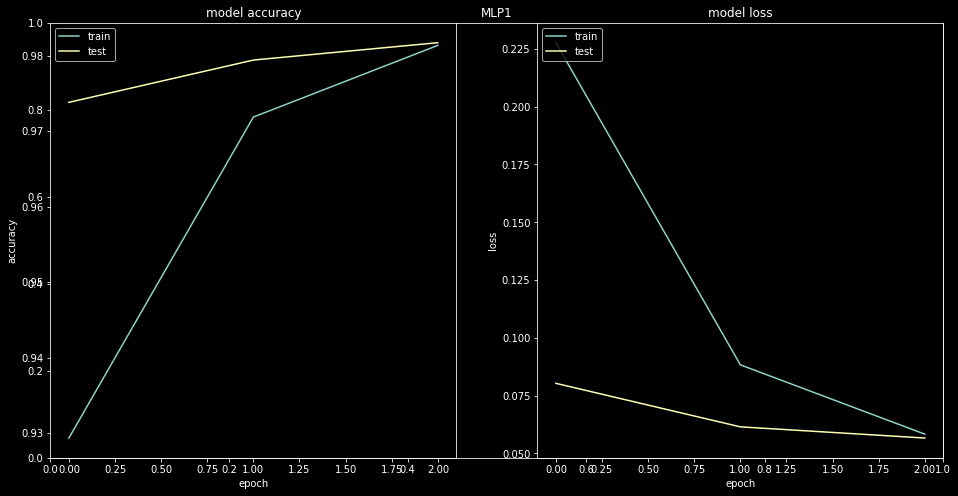

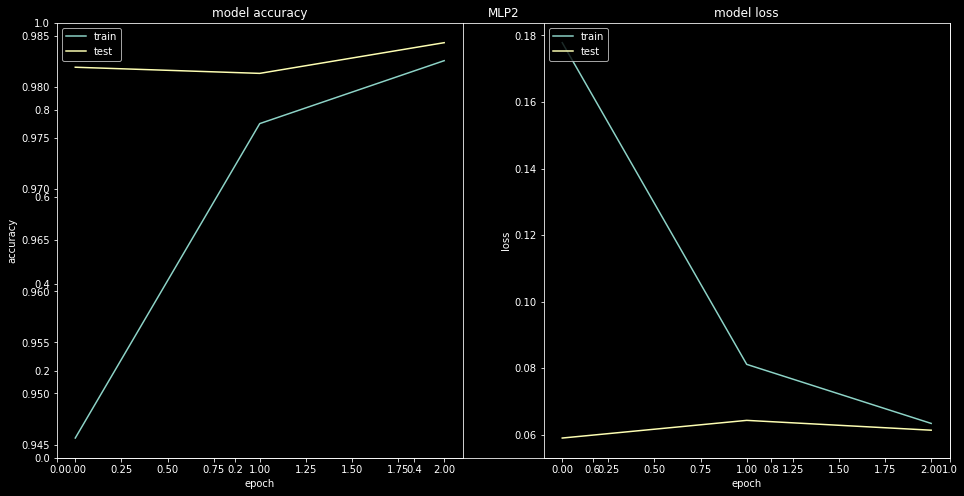

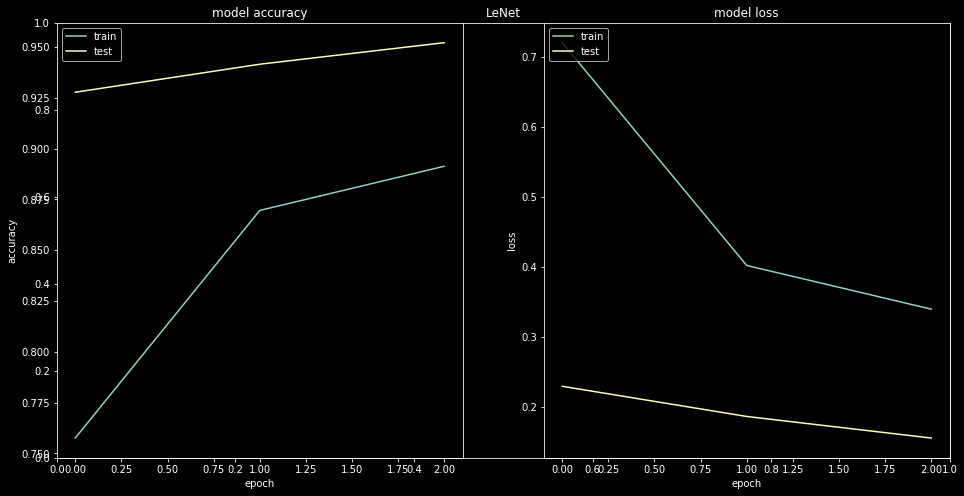

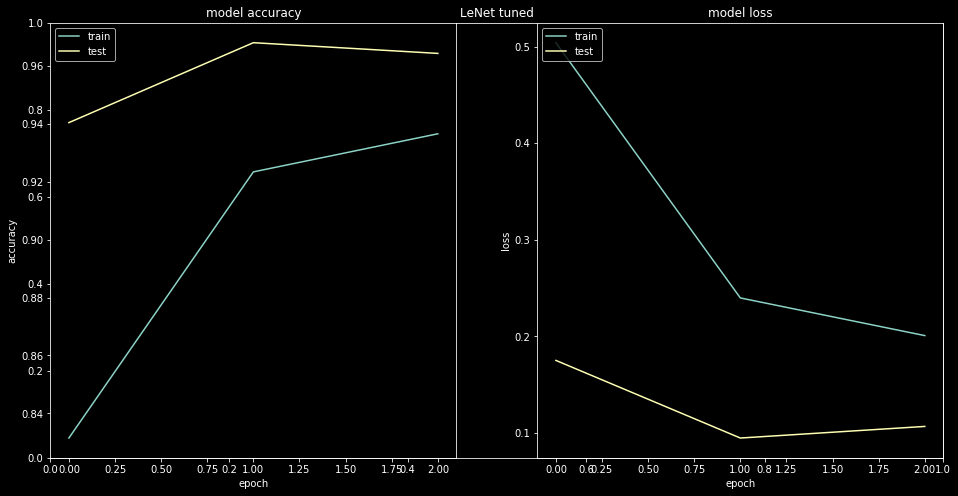

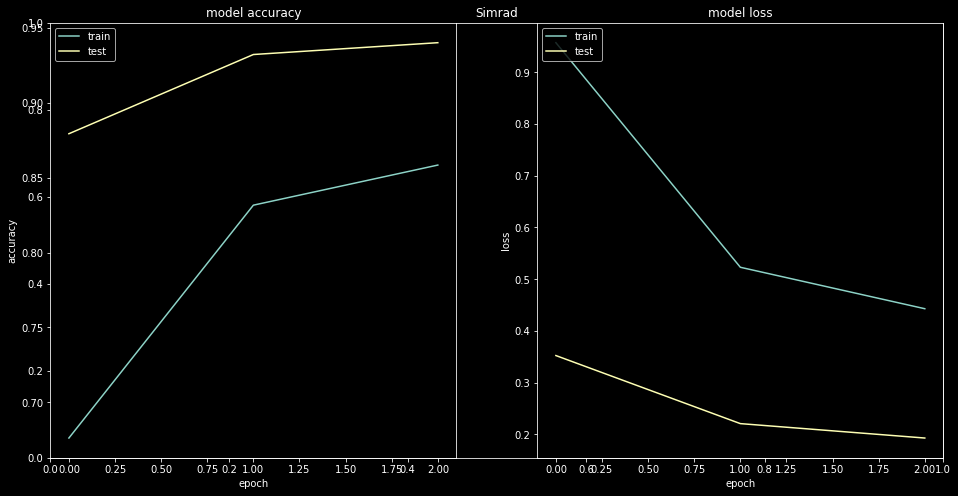

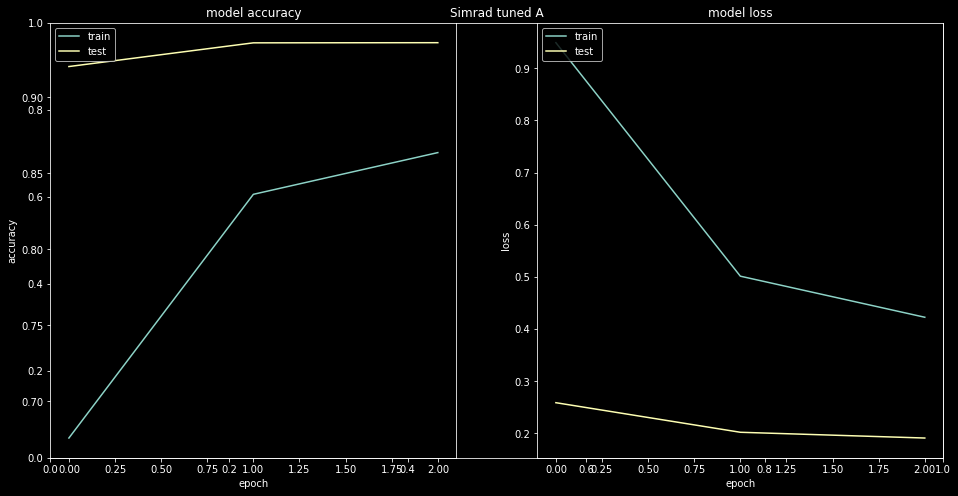

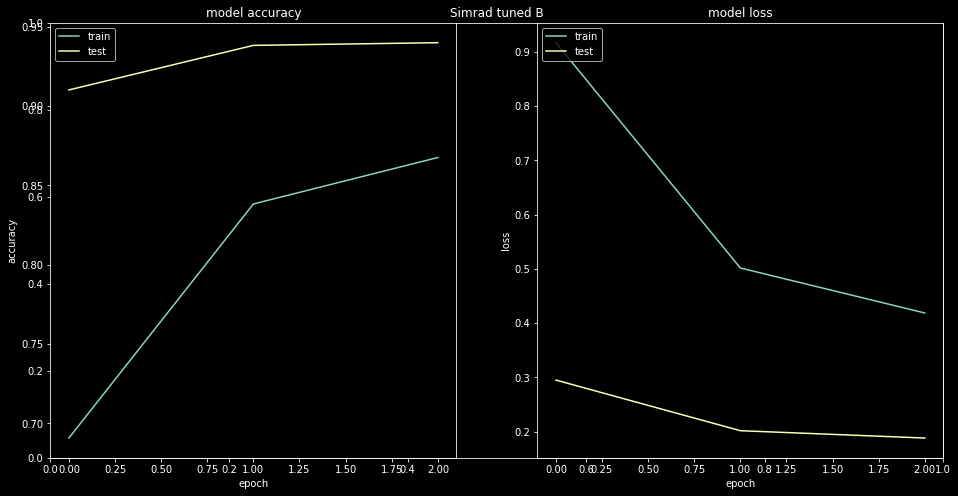

In [16]:
mt.plot_history(history_mp1, 'MLP1')
mt.plot_history(history_mp2, 'MLP2')
mt.plot_history(history_lenet, 'LeNet')
mt.plot_history(history_lenet_tuned, 'LeNet tuned')
mt.plot_history(history_simrad, 'Simrad')
mt.plot_history(history_simrad_tuned_a, 'Simrad tuned A')
mt.plot_history(history_simrad_tuned_b, 'Simrad tuned B')